# Protein design VAE
### Xinran Lian, Andrew Ferguson, Rama Ranganathan
---
All codes should be run under Python3.  
Prior to running this material, please 
* Make sure you already installed the newest version of the following python packages: **numpy, pandas, numba, scipy, matplotlib, torch, sklearn, Bio**. [Conda environment](https://www.anaconda.com) will be helpful.   

* If your input sequences are not aligned, you are recommended to align it with pySCA/scaProcessMSA. See SCA documention [here](https://ranganathanlab.gitlab.io/pySCA/)  
  We have a shell script *runsca_SH3* for MSA of SH3, it is necessary if you want to evaluate the VAE model with SCA. Please install all SCA dependencys before excuting this script from the command line as:  
  
  ./runsca_SH3.sh


* Execute the scripts from the command line as follows:   

  cd source  
  ./preprocessing.py ../Inputs/sh3_59.fasta -n SH3  
  ~~./train_model.py -n SH3~~  <font color='blue'> Note: For the SH3 example, training model is not necessary because a trained model file is already provided in source/  
Performance of the dropout layer is unstable. It is recommended to do 5-10 trials of training and pick up the best.
</font>   

  
* Additionally, please run the following script to generate new sequences:  

  ./Generate_many_seqs.py -g 1000 -n SH3
 
Explain roles of each script:  
* *preprocessing.py*:  
  Convert the fasta file to ont-hot Potts representation.  
   
   
* *train_model.py*:  
  Train the VAE model.  
  
  
* *Generate_many_seqs_SH3.py*: 
  Generate new sequences and compute their  
    * $log(tr(H^TP))$
    * Min Hamming distance from MSA
    (Please run *./Generate_many_seqs_SH3.py --help* for details of the arguments.)

In [1]:
from __future__ import division 
import sys
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy.spatial import distance
from scipy.stats import scoreatpercentile 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
sys.path.append('./source')
from model import *
import toolkit
import scaTools as sca
sys.path.append('../')

device = torch.device("cpu")

/Users/xinran/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


---
## Import the dataset and VAE model

### Import dataset
We are going to use the following annotations in this notebook:
* **$N$** number of samples
* **$q$** number of one-hot features
* **$n$** number of amino acid residues in a sequence

In [4]:
# The -n argument of ./preprocessing.py
proteinname = 'SH3'

In [5]:
path = 'Outputs/'

# Import the Potts sequence. 
parameters = pickle.load(open(path + proteinname + ".db", 'rb'))

q_n = parameters['q_n'] # Number of possible residues on each position
v_traj_onehot = parameters['onehot'] # The one-hot encoded sequences

N=np.size(v_traj_onehot,axis=0) #number of samples 
q=np.size(v_traj_onehot,axis=1) #number of one-hot features
n=np.size(q_n) # number of amino acid residues in a sequences

print("Number of samples = ", N)
print("Number of features = ", q)
print('Number of amino acids = ', n)

Number of samples =  5299
Number of features =  1178
Number of amino acids =  59


### Import VAE

In [5]:
# Load the trained VAE
d=3
model = VAE(q,d)
model_init = VAE(q,d)
model.load_state_dict(torch.load('source/VAE_'+proteinname+'.pyt',map_location='cpu'))
model.eval()

VAE(
  (en1): Linear(in_features=1178, out_features=1767, bias=True)
  (en2): Linear(in_features=1767, out_features=1767, bias=True)
  (en3): Linear(in_features=1767, out_features=1767, bias=True)
  (en_mu): Linear(in_features=1767, out_features=3, bias=True)
  (en_std): Linear(in_features=1767, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=1767, bias=True)
  (de2): Linear(in_features=1767, out_features=1767, bias=True)
  (de22): Linear(in_features=1767, out_features=1767, bias=True)
  (de3): Linear(in_features=1767, out_features=1178, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1767, eps=1e-05, momentum=0.1, affine=True, tr

---
## Model Validation

### Internal validation: how well the model reconstruct natural sequences
**1. Reconstruction accuracy**

In [5]:
# Reconstruct ont-hot representation for input sequences by the trained VAE by encoding and decoding.
def reconstruct(model, sequence_list, q_n):
    model.eval()
    real_ref = torch.FloatTensor(sequence_list) 
    pred_ref, mu_ref, logvar_ref = model(real_ref)
    pred_ref = pred_ref.cpu().detach().numpy().reshape([-1,sum(q_n)])
    
    sequence_list = sequence_list.reshape([-1,sum(q_n)])
    length = np.size(sequence_list,axis=0)
    reconstruct_nothot = np.zeros([length,len(q_n)])
    
    for i in range(length):
        for j in range(len(q_n)):
            start = np.sum(q_n[:j])
            end = np.sum(q_n[:j+1])
            reconstruct_nothot[i,j] = np.argmax(pred_ref[i,start:end])
    return (reconstruct_nothot)

In [7]:
real_nohot_list = toolkit.convert_nohot(v_traj_onehot, q_n)
z_test = model.get_z(torch.FloatTensor(v_traj_onehot)).cpu().detach().numpy() 
test_recons = reconstruct(model, v_traj_onehot, q_n)
Hamming_list = [int(n*distance.hamming(test_recons[i],real_nohot_list[i])) for i in range(len(v_traj_onehot))]

mean_acc = np.mean((test_recons==real_nohot_list).astype(int),axis=0) # List of mean reconstruction accuracy

print("Mean accuracy = %2f" %np.mean(mean_acc))

Mean accuracy = 0.627451


Explain the variables:  
  
* **real_nohot_list** int representation of MSA  
* **z_test** The latent variables  
* **test recons** int representation of reconstructed sequences  
* **Hamming_list** Hamming distances from the original MSA and reconstructed sequences.   
* **mean_acc** List of mean reconstruction accuracy at each position ($accuracy^i$), namely  
  
$accuracy^i=\frac{1}{N}\sum_{i=1}^{N} \delta(a_i- \hat{a}_i)$ 
  
Then we plot the histogram of reconstruction Hamming distances for MSA and bar plot of $accuracy^i$:

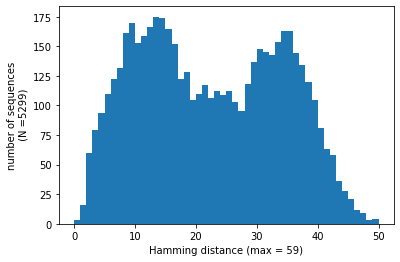

In [8]:
plt.rcParams.update({'font.size': 10})
plt.hist(Hamming_list, max(Hamming_list))
plt.xlabel('Hamming distance (max = %d)' %n)
plt.ylabel('number of sequences\n (N ='+str(len(v_traj_onehot))+')')
plt.show()

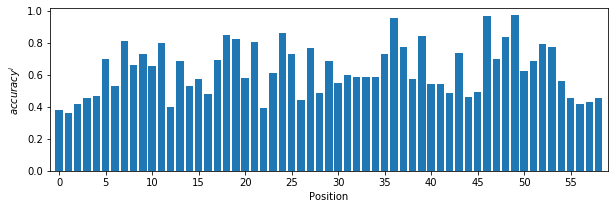

In [9]:
plt.figure(figsize = (10,3))
plt.bar(np.arange(n),mean_acc)
plt.xticks(np.arange(0,n,5))
plt.xlim([-1,n])
plt.xlabel('Position')
plt.ylabel('$accuracy^i$')
plt.show()

To compare reconstruction accuracy with first order statistics, at beginning we load the SCA database of MSA:

In [10]:
try:
    db = pickle.load(open('Inputs/sh3_59.db','rb'))
    Dseq = db['sequence']  #the results of scaProcessMSA
    Dsca = db['sca']       #the results of scaCore
    Dsect = db['sector']   #the results of scaSectorID

    Di_list = Dsca['Di']
except FileNotFoundError:
    print('Please firstly proceed SCA pipeline on your fasta file. (See begining of this notebook)')
    raise

In [11]:
acc_tmp = (test_recons==real_nohot_list).astype(int)
mean_acc = np.mean(acc_tmp,axis=0) # List of mean reconstruction accuracy

We compare the $accuracy^i$ with Kullback-Leibler relative entropy $D_i$ at each position $i$:   
  
  $D_i^a = f_i^aln\frac{f_i^a}{p^a}+(1-f^a_i)ln\frac{1-f_i^a}{a-p^a}$  
  
  $D_i = \sum_{a=0}^{20}f^a_iln(\frac{f_i^a}{p^a})$ 
    
  where  
*  $a_i$ is the amino acid at position $i$ in the real sequence.   
*  $p^a$ is the background distribution of amino acid $a$  
*  $f_i^a$ is frequency of amino acid $a$ at position $i$
  
The following scatter diagram is going to show the relationship between $D_i$ and $accuracy^i$

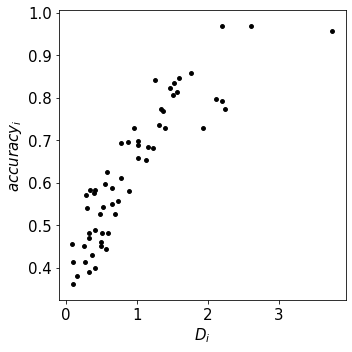

In [12]:
set_size = 15

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax1.set_ylabel('$accuracy_i$', fontsize=set_size)
ax1.set_xlabel('$D_i$', fontsize=set_size)
ax1.scatter(Di_list, mean_acc, c='k',s = set_size)
ax1.tick_params(axis='y',labelsize=set_size)
ax1.tick_params(axis='x',labelsize=set_size)
fig.tight_layout()
plt.show()

**2. VAE log probability**
  
Using the model trained by MSA, the probability of each input sequence can be estimated as 
  
$logP(x|z) \propto log[tr(H^TP)]$  

where  
* $H$ is an $21×L$ matrix representing the one-hot encoding of a sequence  
* $P$ is the probability weight matrix generated by feeding the network a sequence. 

For the first step, we compute **log_p_list**, which is the list of $log[tr(H^TP)]$ for each sequence. 

*Ref. https://arxiv.org/abs/1712.03346*

In [13]:
pred_ref,_,_ = model(torch.FloatTensor(v_traj_onehot))
p_weight = pred_ref.cpu().detach().numpy()
log_p_list = np.array(toolkit.make_logP(v_traj_onehot, p_weight,q_n))

Elapsed time 3.20 (s)


Then we show the $H$ and $P$ matrix of a sequence of interest.  
  
**Hint**: Run this block, text the index of your interested sequence in the text box on the right side of the scroll bar, then press Enter.

In [14]:
def show_matrices(test_seq):
    print("Reconstruction Hamming distance: ", Hamming_list[test_seq])
    cmap = 'hot'
    plt.rcParams.update({'font.size': 14})

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
    gened = axes[0].imshow(toolkit.make_matrix(v_traj_onehot[test_seq], n, q_n),cmap = cmap)
    axes[0].set_title('one-hot encoding matirx $H$')

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(gened, cax=cax)

    msa = axes[1].imshow(toolkit.make_matrix(p_weight[test_seq], n, q_n),cmap = cmap)
    axes[1].set_title('Reconstruction probability weight matrix $P$')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(gened, cax=cax)

    plt.tight_layout()
    
interact(show_matrices, test_seq = N-1)
plt.show()

interactive(children=(IntSlider(value=5298, description='test_seq', max=15894, min=-5298), Output()), _dom_cla…

Finally, we plot the adjusted log probability, which is $log[tr(H^TP)]$ normalized by setting completely accurate reconstruction as zero, equally 

$log[tr(H^{T}P)] - log(L)$  v.s. reconstruction Hamming distance.  
  
The log Probability is negatively correlated with reconstruction Hamming distance. In other words, higher reconstruction accuracy means higher probability of a sequence to occur.

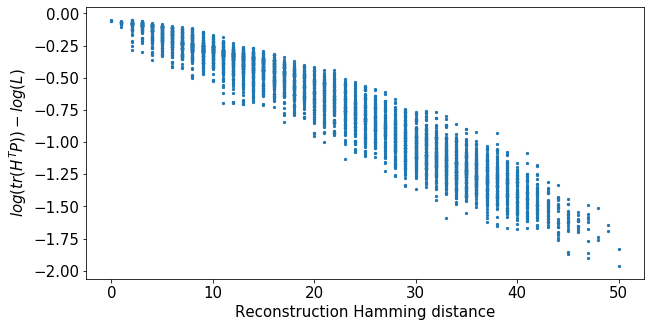

In [15]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(Hamming_list,log_p_list, s = 5)
plt.xlabel('Reconstruction Hamming distance')
plt.ylabel('$log(tr(H^{T}P)) - log(L)$')
#plt.ylim([-np.log(n),0])
plt.show()

maxlogP = -0.050


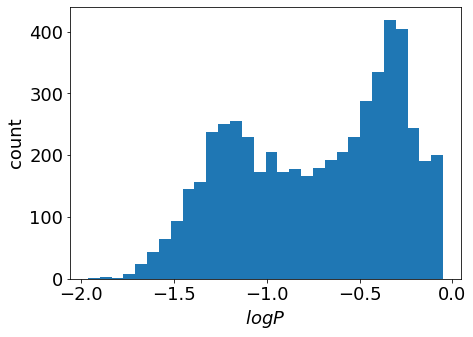

In [16]:
plt.figure(figsize = [7,5])
print('maxlogP = %.3f' %max(log_p_list))
plt.rcParams.update({'font.size': 18})
plt.hist(log_p_list, 30)
plt.ylabel('count')
plt.xlabel('$logP$')
plt.show()

**3. Mapping MSA in the 3D VAE latent space**
 

In [76]:
# Relative enrichment
RE = np.load('Inputs/RE.npz')['RE_mapping']
records_MSA = parameters['seq']
for num, i in enumerate(records_MSA):
    if 'DADDA' in i:
        sho1 = i
        sho1_id = num
        break

-3.003069001556713


/Users/xinran/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xinran/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


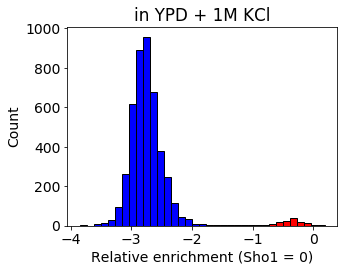

In [18]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = [5,4])
N_hist1, bins, patches = ax.hist(RE,35,color = 'r', edgecolor='k',linewidth=1)
ax.set_xlabel('Relative enrichment (Sho1 = 0)')
ax.set_ylabel('Count')
ax.set_title('in YPD + 1M KCl')
for i in range(0,18):    
    patches[i].set_facecolor('b')
plt.tight_layout()
plt.show()

In [20]:
RE_plot = []
good_seqs = []
thresh =  -1.7185 #4sigma
for num, i in enumerate(RE):
    if i<thresh:
        pass
    elif i>=thresh:
        RE_plot.append(i)
        good_seqs.append(num) # Rescuing sequences with RE higher than threshold
    else:
        continue

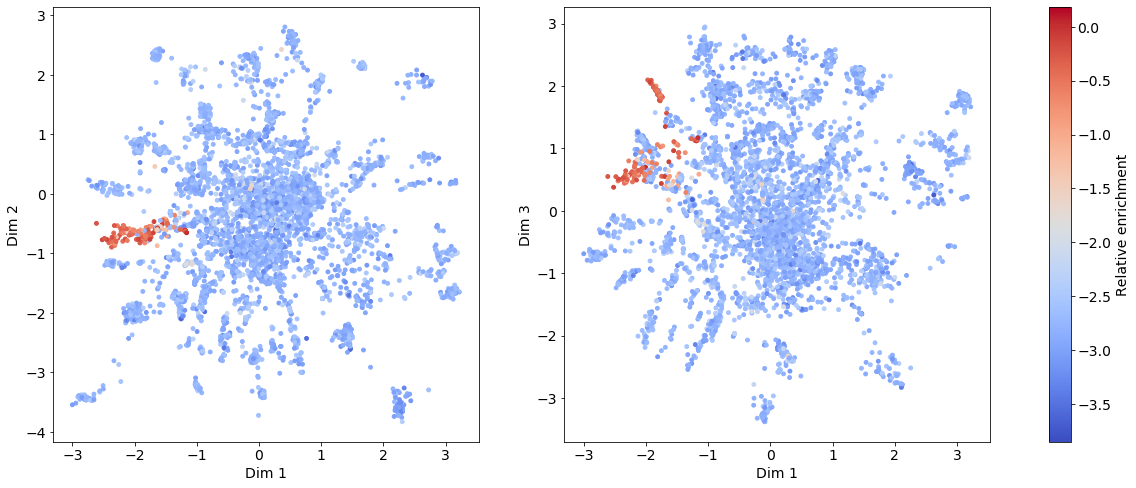

In [19]:
# Relative enrichment with latent dimension for all sequences
fig, axs = plt.subplots(1,2,figsize=[21,8])
c = RE
cmap = plt.cm.coolwarm
s1 = axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c = c, cmap=cmap)#, vmax = -0.5730, vmin = -2.63)
s2 = axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c = c, cmap=cmap)#, vmax = -0.5730, vmin = -2.63)

axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')

cbar = fig.colorbar(s1, ax = axs[:], location = 'right')
cbar.ax.set_ylabel('Relative enrichment')

plt.show()

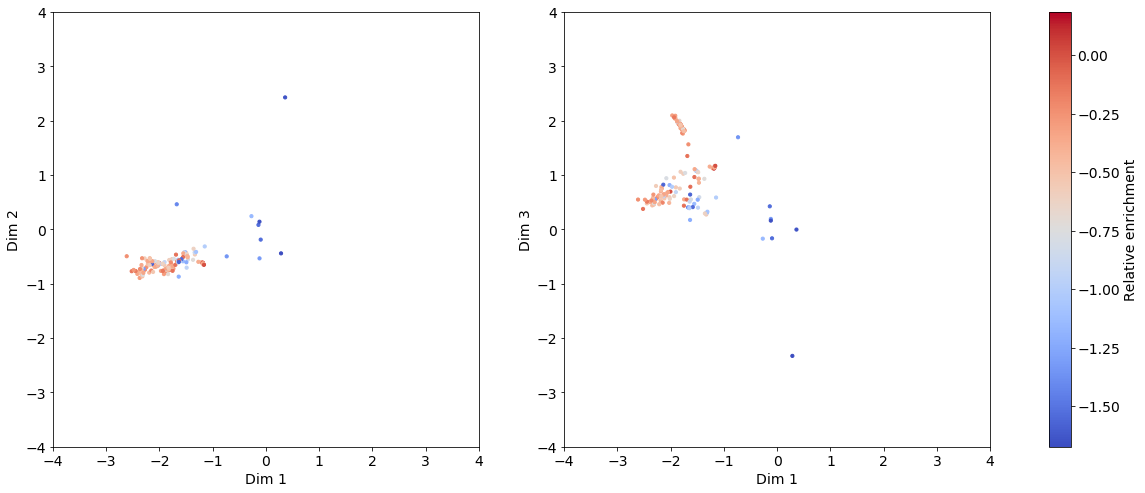

In [21]:
# Relative enrichment with latent dimension for rescuing sequences
fig, axs = plt.subplots(1,2,figsize=[21,8])
c = RE_plot
cmap = plt.cm.coolwarm
s1 = axs[0].scatter(z_test[good_seqs,0], z_test[good_seqs,1],s=10, c = c, cmap=cmap)
s2 = axs[1].scatter(z_test[good_seqs,0], z_test[good_seqs,2],s=10, c = c, cmap=cmap)
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')

for i in range(2):
    axs[i].set_xlim([-4,4])
    axs[i].set_ylim([-4,4])

cbar = fig.colorbar(s1, ax = axs[:], location = 'right')
cbar.ax.set_ylabel('Relative enrichment')

plt.show()

In [22]:
RE_color = []
for i in RE:
    if i>thresh:
        RE_color.append('r') # rescuing sequences
    elif i<=thresh:
        RE_color.append('b') # non-rescuing sequences
    else:
        RE_color.append('darkgrey') # no data

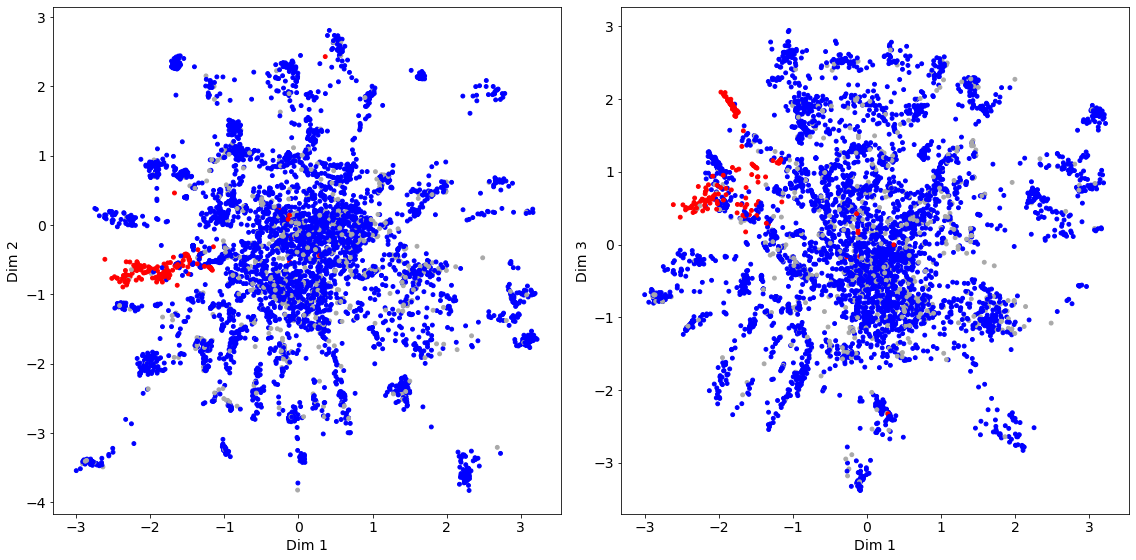

In [23]:
# red: rescuing sequences; blue: non-rescuing sequences; grey: no data
fig, axs = plt.subplots(1,2,figsize=[16,8])
c = RE_color
axs[0].scatter(z_test[:,0], z_test[:,1],s=15, c = c)
axs[1].scatter(z_test[:,0], z_test[:,2],s=15, c = c)
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
plt.tight_layout()
plt.show()

### Local sampling

Sample sequences from where rescuing sequences are located.

In [24]:
n_sp = 150
np.random.seed(98850) #700
z_gen=np.random.normal(np.mean(z_test[good_seqs,:], axis = 0), 
                       np.var(z_test[good_seqs,:], axis = 0), (n_sp, d))
data = torch.FloatTensor(z_gen).to(device)
data = model.decode(data) # Use the decoding layer to generate new sequences.
v_gen = data.cpu().detach().numpy()

sample_list = []
for i in range(n_sp): # number of sampling points
        for k in range(10): # number of trials at each point
            v_samp_nothot = toolkit.sample_seq(k, q, n, q_n, i, v_gen)
            sample_list.append(v_samp_nothot)
localsmp = toolkit.convert_alphabet(np.array(sample_list), parameters['index'], q_n)

# Filtering to maximize diversity.
chooseset = np.unique(localsmp) # Firstly remove duplicated sequences
choose = [chooseset[0]]
# Make min Hamming distance > 3 for every pair of sequences.
for i in chooseset:
    aa2inti = [toolkit.aa2int(j,toolkit.plm_dict.dict_aa2int) for j in choose]
    if toolkit.minHamming(toolkit.aa2int(i, toolkit.plm_dict.dict_aa2int), aa2inti)>3:
        choose.append(i)
        
# manually adjust a few sequences to reduct affect of misplacement in alignments.
for num, i in enumerate(choose):
    if i[33]=='-' and i[35] in ['R','K','N']:
        choose[num] = i[:33]+i[34]+'G'+i[35:]
    if 'EG-W' in i:
        choose[num] = i.replace('EG-W', 'EGRW')
    if 'SG-W' in i:
        choose[num] = i.replace('SG-W', 'SGRW')
    if 'KG-W' in i:
        choose[num] = i.replace('KG-W', 'KGRW')
    if i[0] == '-':
        choose[num] = i.replace(i[0], 'N')
print('%d chosen sequences.' %len(choose))

896 chosen sequences.


In [25]:
# compute cloest identity to MSA.
int_local = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in choose]
int_msa = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in parameters['seq']]
min_Ham_local = []
for i in int_local:
    min_Ham_local.append(toolkit.minHamming(i, int_msa))

---
### External validation: 
* Evaluate $10^4$ generated sequences by SCA (requires additional job)
* Pairwise distance and PCA

---
**1. Evaluate $10^4$ generated sequences by SCA (optional)**  
All technical details about SCA can be found in [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004817). Here we only demonstrate the codes to retrieve the distribution of correlations and sector decomposition, to show that our model have learned statistical patterns in the MSA.  

If you want to analyze your VAE generated sequences by SCA, run the following command line to generate 10000 SH3 sequences without filtering. Notice that we need all of the sequences to maintain the statistic pattern, and 10000 sequences are enough for stable pattern.  
If you want to play with other protein families, modify *./Generate_many_seqs.py* from line 213.
  
  ./Generate_many_seqs.py -n SH3 -c 1e4 -a
  
<font color='red'> 
* **Warning:**  
    The SCA database file is very large (>700MB).  
    Because SCA is expensive, do not enable SCA (-a) while generating large number (millions) of sequences. 
</font> 
  
After computing, we load the SCA databases for both MSA and VAE generated sequences:

In [31]:
db = pickle.load(open(path + proteinname+'1e4_sca.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

db_ref = pickle.load(open('Inputs/sh3_59.db','rb'))
Dseq_ref = db_ref['sequence']  
Dsca_ref = db_ref['sca']       
Dsect_ref = db_ref['sector']

In [32]:
print("After processing, the alignment size of VAE generated sequences is %i sequences and %i positions" % \
      (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))
print()
print("After processing, the alignment size of MSA is %i sequences and %i positions" % \
      (Dseq_ref['Nseq'], Dseq_ref['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq_ref['effseqs']))

After processing, the alignment size of VAE generated sequences is 8463 sequences and 59 positions
With sequence weights, there are 6911 effective sequences

After processing, the alignment size of MSA is 4551 sequences and 59 positions
With sequence weights, there are 2695 effective sequences


In [33]:
def scaMat(alg, seqw=1, lbda=0, freq0=np.ones(20) / 21,):
    N_seq, N_pos = alg.shape
    N_aa = 20
    if isinstance(seqw, int) and seqw == 1:
        seqw = np.ones((1, N_seq))
    freq1, freq2, freq0 = sca.freq(alg, Naa=N_aa, seqw=seqw, lbda=lbda, freq0=freq0)
    return freq1, freq2 - np.outer(freq1, freq1)

In [34]:
gen_1e4 = np.load('Outputs/SH31e4gen_data.npz')
int_new = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in gen_1e4['seq'][:N]]
new_f1, new_f2 = scaMat(np.array(int_new), seqw=1, lbda=0, freq0=np.ones(20) / 21,)
int_msa = [toolkit.aa2int(i,toolkit.plm_dict.dict_aa2int) for i in parameters['seq']]
msa_f1, msa_f2 = scaMat(np.array(int_msa), seqw=1, lbda=0, freq0=np.ones(20) / 21,)

We firstly show the $1^{st}$ ($D_i$) and $2^{nd}$ (${\widetilde{C}_{ij}}$) order statistics of MSA between MSA and  sequences generated by VAE. 

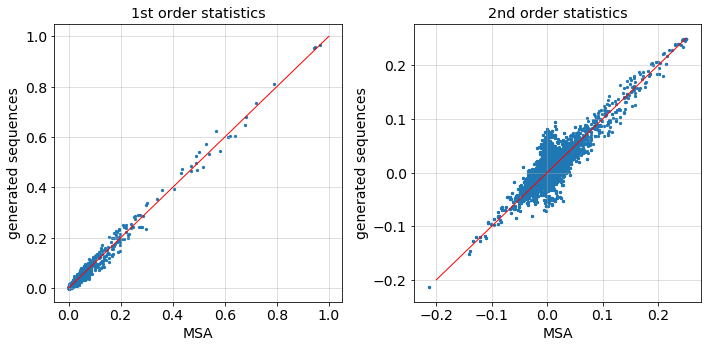

In [35]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.rcParams.update({'font.size': 12})

for i in range(2):
    axs[i].set_ylabel('generated sequences')
    axs[i].set_xlabel('MSA')
    axs[i].grid(alpha = .5)

axs[0].scatter(msa_f1,new_f1,s=5)
axs[0].plot([0,1.],[0,1.],'r',lw=1)
axs[0].set_title('1st order statistics')

axs[1].scatter(msa_f2,new_f2,s=5)
axs[1].plot([-.2,.25],[-.2,.25],'-r',lw=1)
axs[1].set_title('2nd order statistics')

plt.tight_layout()
plt.show()

In [36]:
import scipy.cluster.hierarchy as sch

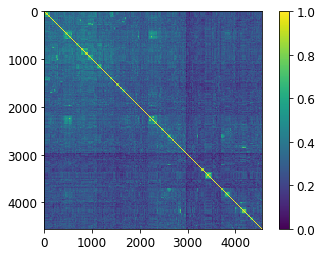

In [37]:
Z = sch.linkage(Dsca_ref['simMat'], method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z, no_plot = True)
ind = R['leaves']
plt.imshow(Dsca_ref['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

* Sector decomposition

In [38]:
def Sector_decompos(dsect,dseq, max_n_sec = 3):
    Vpica = dsect['Vpica']
    for k in range(dsect['kpos']):
        iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    sec_groups = [[i] for i in range(dsect['kpos'])]
    sectors = list()

    c = [0.4,0,0.7,0.15,0.9,0.5] 
    for n,k in enumerate(sec_groups):
        s = sca.Unit()
        all_items = list()
        all_Vp = list()
        for i in k: 
            all_items = all_items+dsect['ics'][i].items
            all_Vp = all_Vp+list(dsect['ics'][i].vect)
        svals = np.argsort(all_Vp)    
        s.items = [all_items[i] for i in svals]
        s.col = c[n]
        sectors.append(s)
        if n > max_n_sec-2:
            break

    ic_list = []
    for i,k in enumerate(sectors):
        sort_ipos = sorted(k.items)
        ats_ipos = ([dseq['ats'][s] for s in sort_ipos])
        ic_pymol = (', '.join(ats_ipos))
        #ic_list.append([int(i) for i in ats_ipos])
        ic_list.append(sort_ipos)
        print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
        print(ic_pymol + "\n")
        if i>max_n_sec-2:
            break
    return ic_list

def color_match(sg, sr): # Return a sg to match color with sr. sg: generated; sr: reference
    sg_new = []
    for i in sr:
        sg_tmp = np.argmax([len(set(i) & set(sg_i)) for sg_i in sg])
        sg_new.append(sg[sg_tmp])
    return(sg_new)

To facilitate comparison, here are the SH3 sector definitions in a format suitable for pasting into pyMol:

In [39]:
print('\nMSA:')
sr = Sector_decompos(Dsect_ref,Dseq_ref)
print('Generated sequences:')
sg = Sector_decompos(Dsect,Dseq)
sg = color_match(sg,sr)


MSA:
Sector 1 is composed of 7 positions:
9, 25, 29, 31, 43, 53, 58

Sector 2 is composed of 6 positions:
11, 13, 40, 51, 54, 57

Sector 3 is composed of 1 positions:
41

Generated sequences:
Sector 1 is composed of 8 positions:
11, 13, 28, 40, 48, 51, 54, 57

Sector 2 is composed of 4 positions:
31, 43, 53, 58

Sector 3 is composed of 5 positions:
9, 25, 29, 41, 56



Finally we illustrate the sector decomposition in the bar plot of the $D_i$ list. 

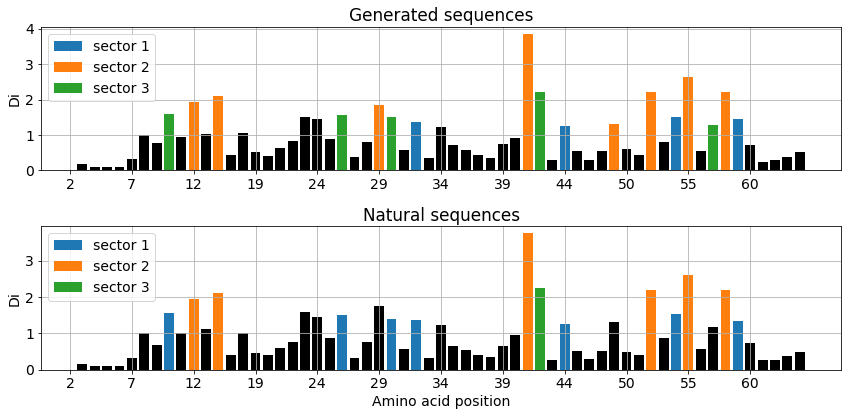

In [40]:
xvals = np.array([i+1 for i in range(len(Dsca['Di']))])
xvals_ref = np.array([i+1 for i in range(len(Dsca_ref['Di']))])
xticks = np.arange(0,len(Dseq_ref['ats']),5)
labels = [Dseq_ref['ats'][k] for k in xticks]

cmap = plt.cm.tab20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 10)))
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].bar(xvals,Dsca['Di'], color='k')
axs[1].bar(xvals_ref,Dsca_ref['Di'], color='k')
axs[0].set_title('Generated sequences')
axs[1].set_title('Natural sequences')

for i in range(Dsect['kpos']):
    axs[0].bar(xvals[sg[i]], Dsca['Di'][sg[i]], label = 'sector '+str(i+1))
for i in range(Dsect_ref['kpos']):
    axs[1].bar(xvals[sr[i]], Dsca_ref['Di'][sr[i]], label = 'sector '+str(i+1))

for i in range(2):
    axs[i].set_ylabel('Di')
    axs[i].set_xticklabels(labels)
    axs[i].set_xticks(xticks)
    axs[i].grid()
    axs[i].legend()

plt.xlabel('Amino acid position')
plt.tight_layout()

Histogram of pairwise Hamming distance of sequences in MSA and generated ones. It's very slow to plot!

In [41]:
new_seq, _ = toolkit.convert_potts(gen_1e4['seq'], parameters['index'])

In [42]:
pairwise = (n - new_seq @ new_seq.T).reshape([-1,1])
pairwise_MSA = (n - v_traj_onehot @ v_traj_onehot.T).reshape([-1,1])

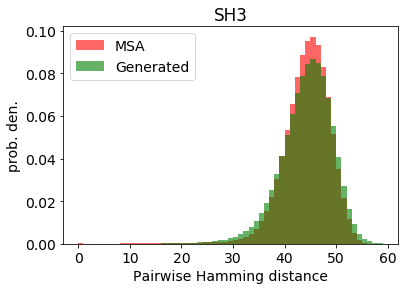

In [43]:
plt.hist(pairwise_MSA, int(max(pairwise_MSA)), density = True, alpha = 0.6, label='MSA',color='r')
plt.hist(pairwise, int(max(pairwise)), density = True, alpha = 0.6, label='Generated',color='g')
plt.xlabel('Pairwise Hamming distance')
plt.ylabel('prob. den.')
plt.title('SH3')
plt.legend()
plt.show()

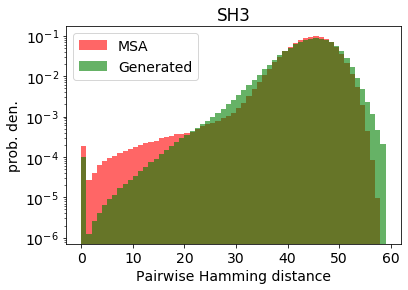

In [44]:
plt.yscale('log')
plt.hist(pairwise_MSA, int(max(pairwise_MSA)), density = True, alpha = 0.6, label='MSA',color='r')
plt.hist(pairwise, int(max(pairwise)), density = True, alpha = 0.6, label='Generated',color='g')
plt.xlabel('Pairwise Hamming distance')
plt.ylabel('prob. den.')
plt.title('SH3')
plt.legend()
plt.show()

In [45]:
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(v_traj_onehot)
msa_array = ipca.transform(v_traj_onehot) #PCA
new_array = ipca.transform(new_seq) 
print(ipca.explained_variance_ratio_)

[0.03581977 0.01836506]


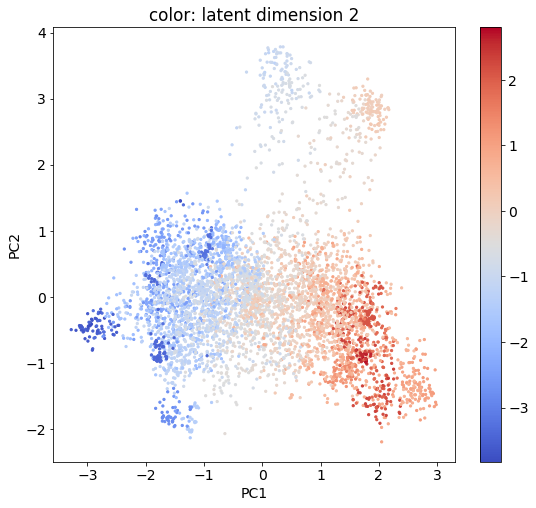

In [46]:
ldim = 1

plt.figure(figsize=[9,8]) # MSA
plt.scatter(msa_array[:,0], msa_array[:,1],s=5, c=z_test[:, ldim],cmap=plt.cm.coolwarm) 
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('color: latent dimension '+str(ldim+1))
plt.show()

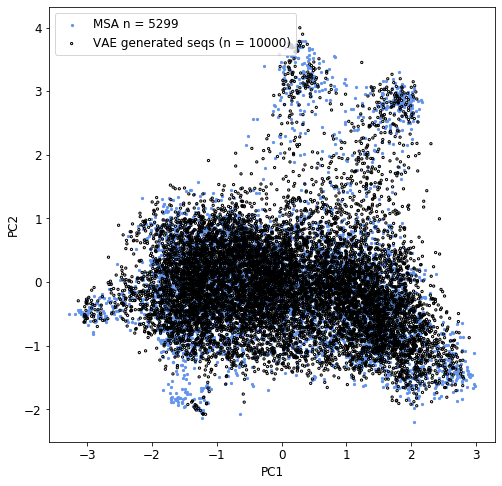

In [47]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=[8,8])
plt.scatter(msa_array[:,0], msa_array[:,1],label = 'MSA n = '+str(N),s=5, c = 'cornflowerblue')
#plt.scatter(msa_array[tst,0], msa_array[tst,1],label='Sho1 orthologs',s=5, c = 'r')
plt.scatter(new_array[:,0], new_array[:,1],label='VAE generated seqs (n = 10000)'
            ,s=5, alpha = 1, facecolors='none', edgecolors='k')
#plt.scatter(new_ortho[:,0], new_ortho[:,1],s=5, c = 'g')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [48]:
v_traj_newall, _ = toolkit.convert_potts(gen_1e4['seq'], parameters['index'])
z_new_all = model.get_z(torch.FloatTensor(v_traj_newall)).cpu().detach().numpy() 

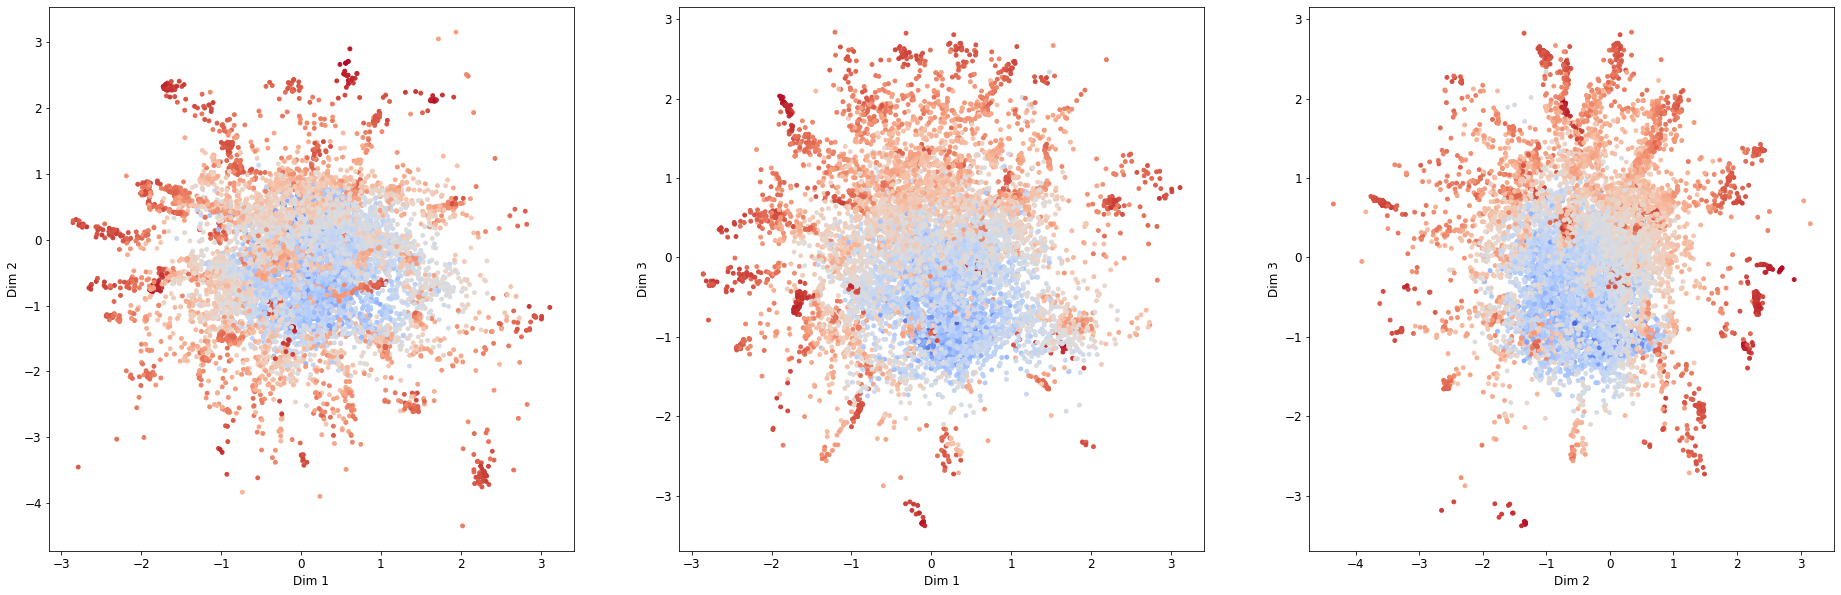

In [49]:
# Distribution of all generated sequenced encoded in latent space
fig, axs = plt.subplots(1,3,figsize=[32,10])
axs[0].scatter(z_new_all[:,0], z_new_all[:,1],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)
axs[1].scatter(z_new_all[:,0], z_new_all[:,2],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)
axs[2].scatter(z_new_all[:,1], z_new_all[:,2],s=15, c=gen_1e4['logP'],cmap=plt.cm.coolwarm)

axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 3')
axs[2].set_xlabel('Dim 2')
axs[2].set_ylabel('Dim 3')
plt.show()

## 2022 update: taxonomy for SH3 homology family

In [21]:
import pandas as pd

In [22]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [23]:
nat_7865 = pd.read_excel('Inputs/20210908_natural_with_taxonomy.xls')
nat_seq_7865 = nat_7865['Sequences'].tolist()
v_traj_onehot_7865, _ = toolkit.convert_potts(nat_seq_7865, parameters['index'])
z_nat_7865 = model.get_z(torch.FloatTensor(v_traj_onehot_7865)).cpu().detach().numpy() 

In [24]:
ortho_list = nat_7865['orthologous_group'].tolist()
u_o = np.unique(ortho_list)[:-1]
cdict=np.arange(len(u_o))

z_x, z_y = [0,0,1], [1,2,2]

In [25]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']

nat_7865['PhyGroup'] = np.nan
for j in range(len(phylogeny)):
    filter_1 = nat_7865['Phylogeny'].str.contains(phylogeny[j])
    nat_7865.loc[filter_1,'PhyGroup'] = phylogeny[j]

nodik = 'non-Dikarya fungi'
phylogeny.append(nodik)
filter_2 = ~nat_7865['Phylogeny'].str.contains('Dikarya')
filter_3 = nat_7865['Phylogeny'].str.contains('Fungi')
nat_7865.loc[filter_2 & filter_3,'PhyGroup'] = nodik

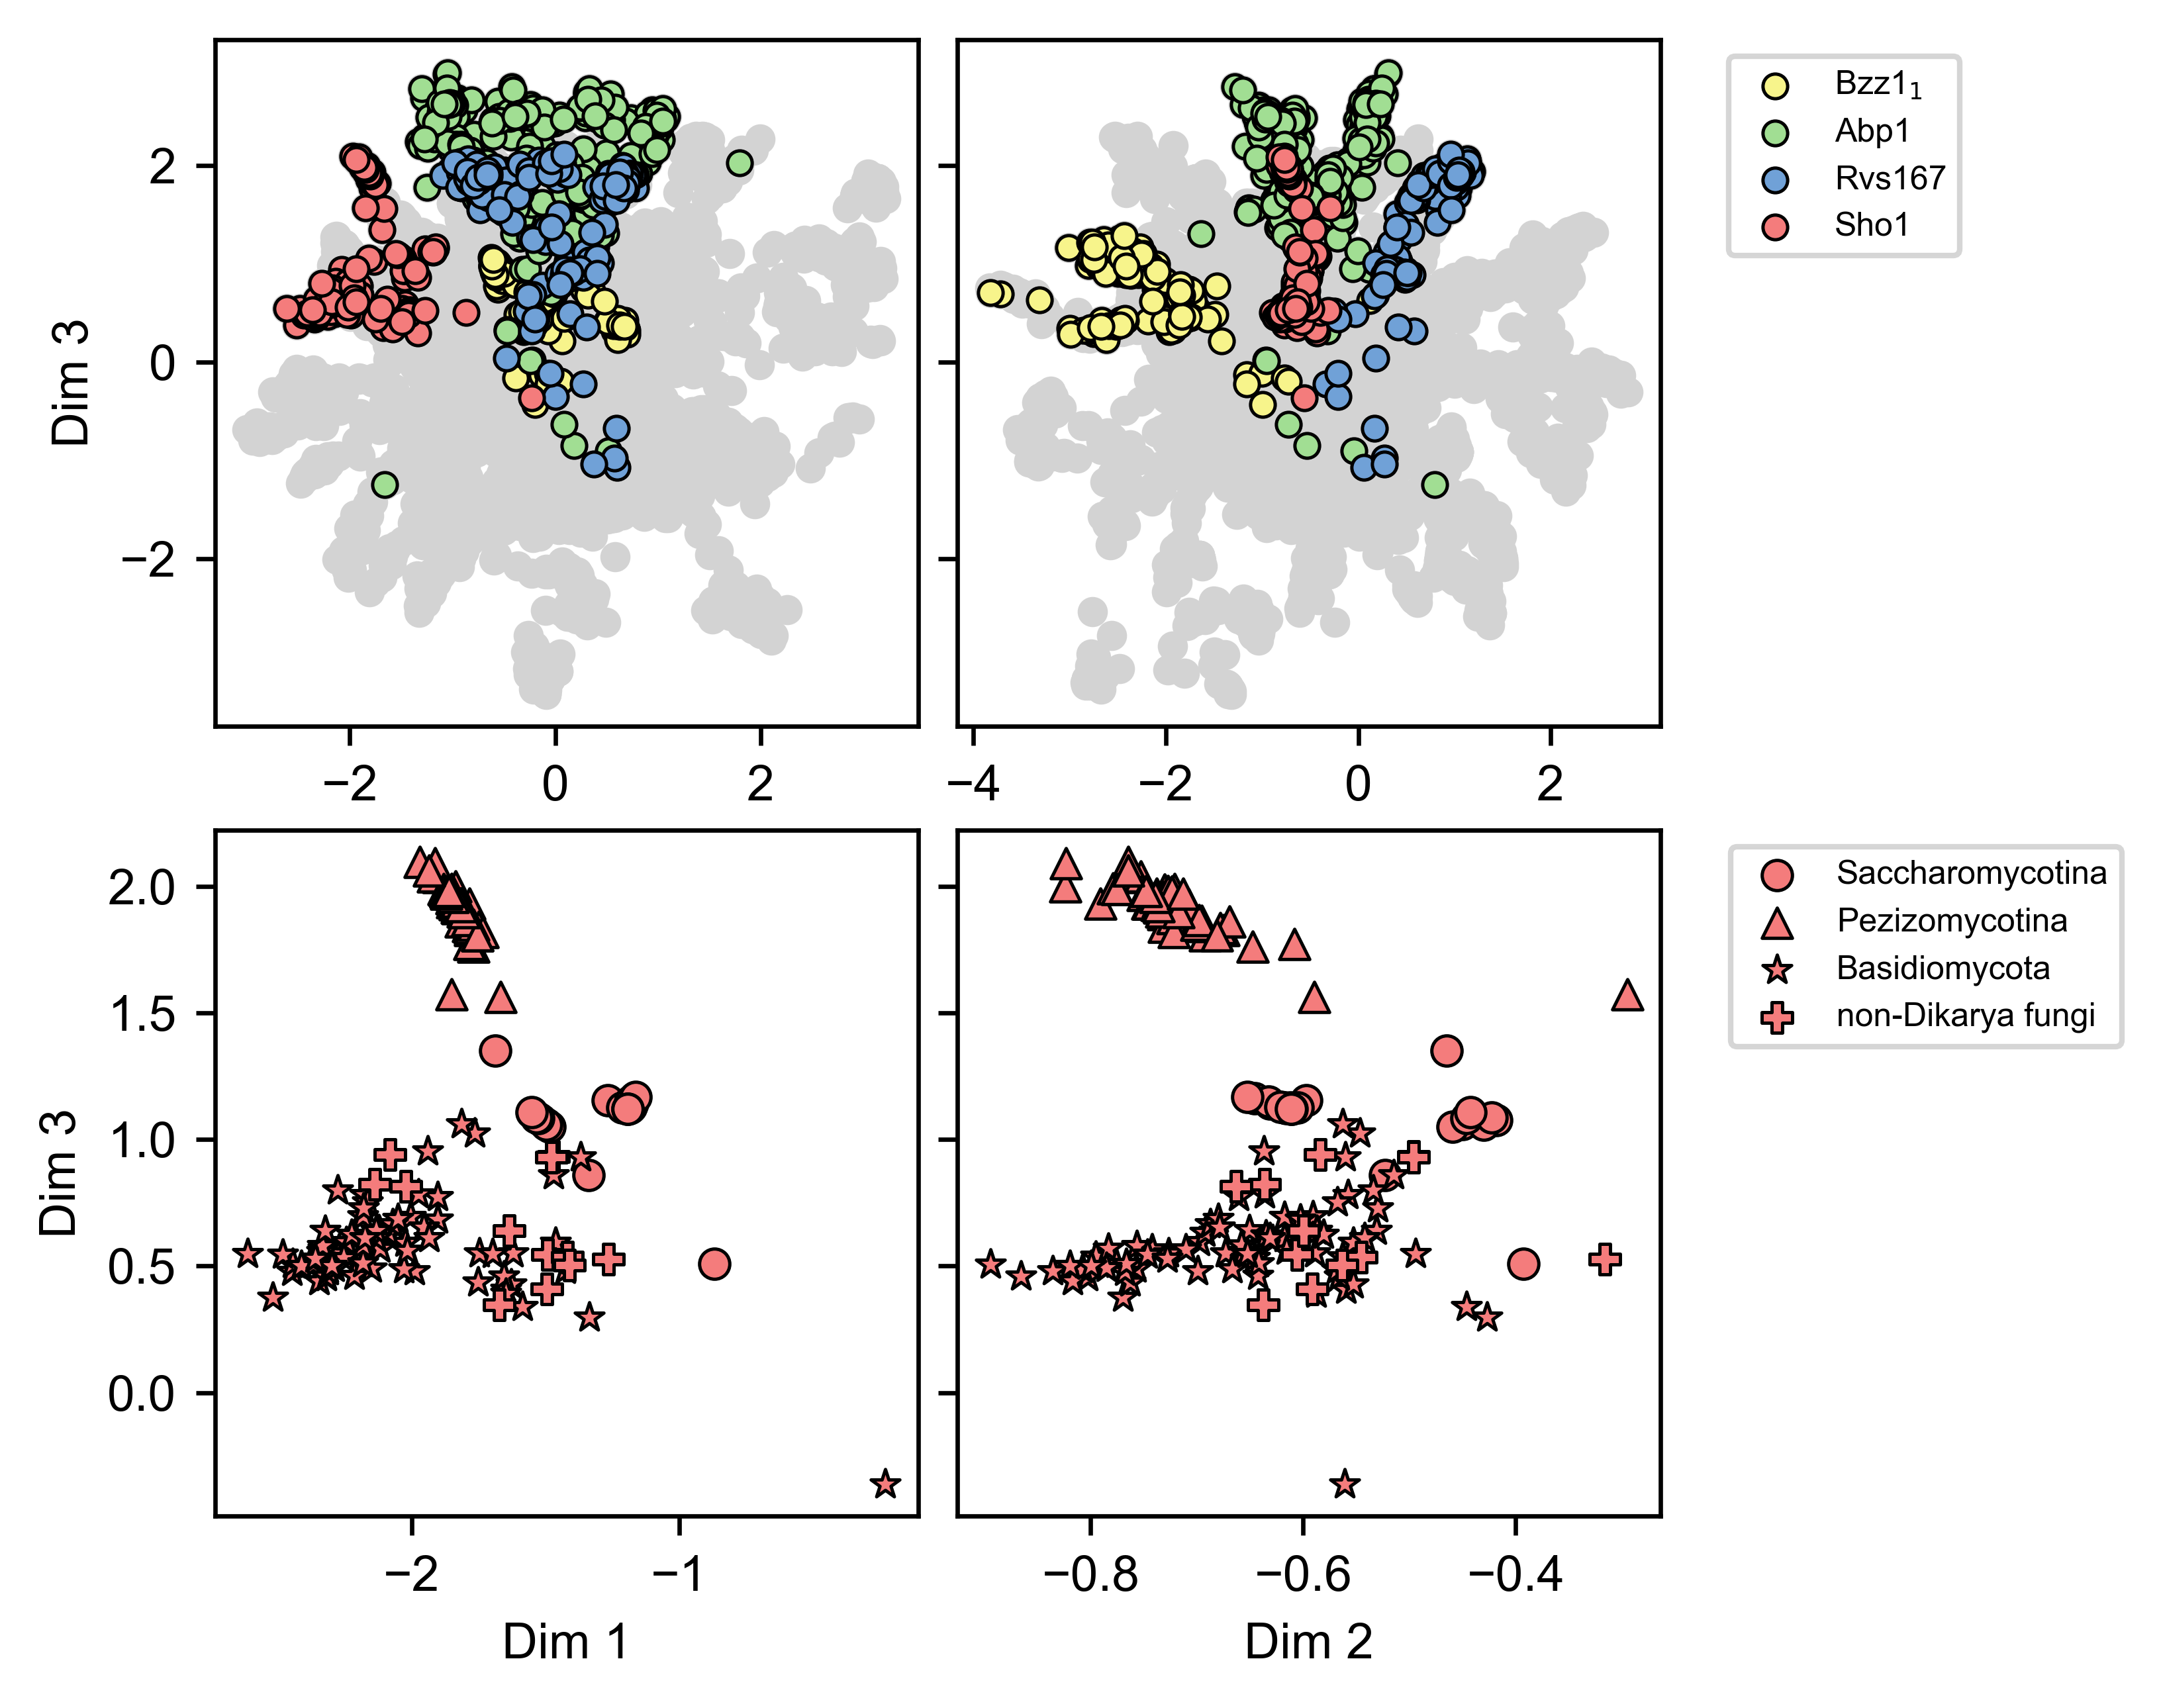

In [29]:
fig, ax = plt.subplots(2,2,figsize=(5.4,4.2),
                       gridspec_kw=dict(height_ratios=[2,2],width_ratios=[2,2]),dpi=600)
for j in range(2):
    ax[0,j].scatter(z_nat_7865[:,j], z_nat_7865[:,2], c = 'lightgray', s = 20)
    ax[j,0].set_ylabel('Dim 3')
    for g in range(4):
        ix = np.where(np.array(ortho_list) == ['KOG3565_1','KOG3655','KOG3771','NOG09120'][g])[0]
        ax[0,j].scatter(z_nat_7865[ix,j], z_nat_7865[ix,2],
                        c = ['#f7f48b','#a1de93','#70a1d7','#f47c7c'][g], 
                        label = [r'Bzz1$_{1}$','Abp1','Rvs167','Sho1'][g], edgecolor = 'k', linewidth=0.6,s = 20)
        
        ix = np.where((nat_7865['PhyGroup'] == phylogeny[g]) & (nat_7865['orthologous_group'] == 'NOG09120'))[0]
        ax[1,j].scatter(z_nat_7865[ix,j], z_nat_7865[ix,2], 
                        marker = ['o','^','*','P'][g], c = '#f47c7c',
                        label = phylogeny[g], edgecolor = 'k', linewidth=0.6,s = 30)
        
ax[0,1].legend(loc='upper right', bbox_to_anchor=(1.45, 1),fontsize=6)
ax[1,1].legend(loc='upper right', bbox_to_anchor=(1.68, 1),fontsize=6)
ax[1,0].set_xlabel('Dim 1')
ax[1,1].set_xlabel('Dim 2')
plt.setp(ax[0,1].get_yticklabels(), visible=False)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
plt.tight_layout(pad=.4)
#plt.savefig('../VAE_design_paper/SIs/vanilla1.pdf')
plt.show()

In [27]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']
phy_list_VAE = []
for j in range(len(phylogeny)):
    filter_4 = nat_7865['Phylogeny'].str.contains(phylogeny[j])
    phy_list_VAE.append(np.array(z_nat_7865[filter_4]))
phylogeny.append('non-Dikarya fungi')
phy_list_VAE.append(np.array(z_nat_7865[filter_2 & filter_3]))

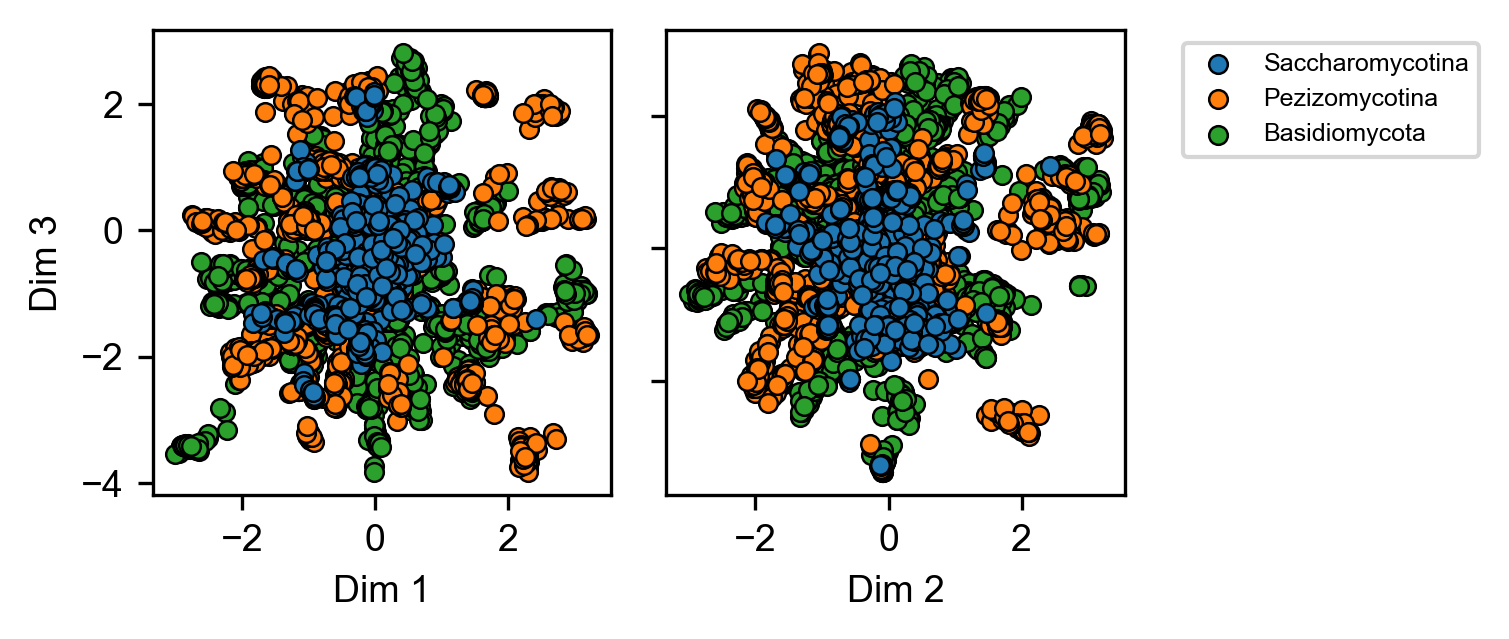

In [30]:
fig, ax = plt.subplots(1,2,figsize=(5.4,2.2),dpi=300)
for i in range(2):
    ax[i].set_xlabel('Dim '+ str(z_x[i+1]+1))
    for j in [0,1,2]:
        ax[i].scatter(phy_list_VAE[j][:,z_x[i]], phy_list_VAE[j][:,z_y[i]], 
                      label = phylogeny[j], edgecolor = 'k',s = 20 ,linewidth=0.6, zorder = 3-j)
ax[1].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
ax[0].set_ylabel('Dim '+ str(z_y[i]+1))
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.tight_layout()
#plt.savefig('../VAE_design_paper/SIs/vanilla2.pdf')
plt.show()